# I’m Something of a Painter Myself

## Description
This is notebook to build model for to convert photo to painting. Our aim is get model with the highest kaggle score possible.

## Data Overview

source : https://www.kaggle.com/competitions/gan-getting-started/data

data type : TFRecord and JPEG images (300 images for monet, 7028 for photo)

data size : 401.1 MB

Images are 256x256 RGB pixels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

In [3]:
# get all file names

MONET_FILENAMES = tf.io.gfile.glob('gan-getting-started/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
# extract image
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES).batch(batch_size)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(batch_size)

2023-08-17 07:27:52.726292: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-08-17 07:27:52.726307: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-17 07:27:52.726311: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-17 07:27:52.726334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-17 07:27:52.726346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


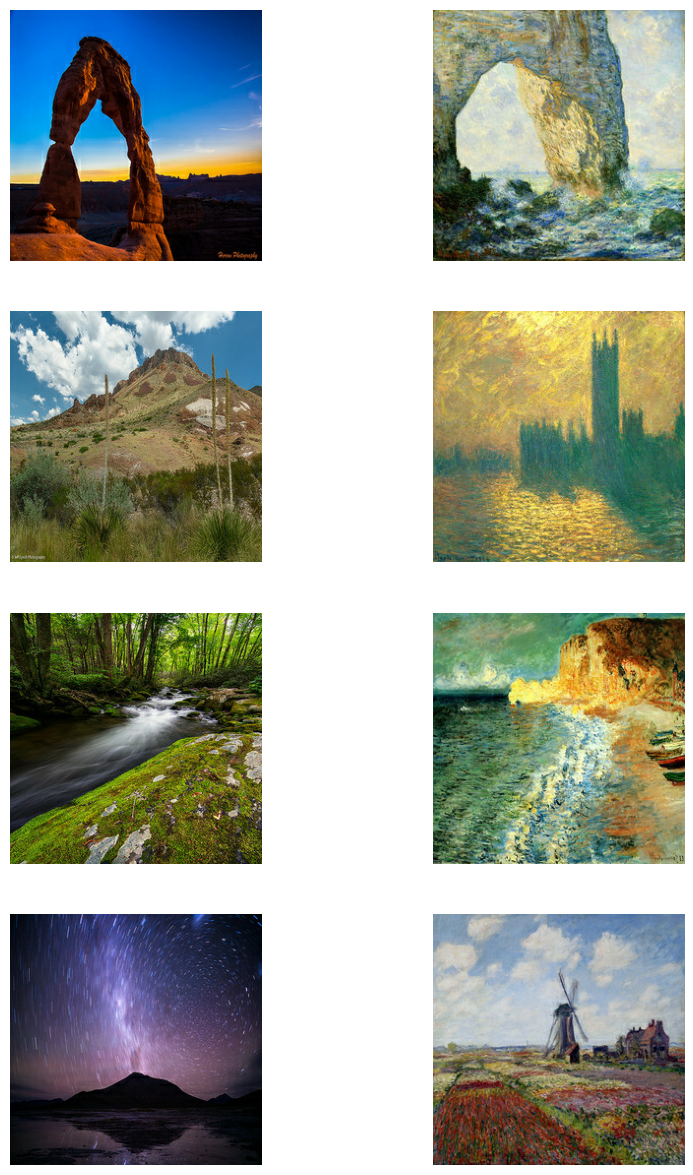

In [7]:
# show sample image
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(monet_ds.take(4), photo_ds.take(4))):
    monet = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    photo = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 0].imshow(photo)
    ax[i, 1].imshow(monet)
plt.show()

### Analysis
We have only 300 images of monet image which I think it's insufficient. Image size is big (256x256 px). So, this would cause a lot of training time.

## Classification
First, I will try build CycleGAN model as based line. Then, try again with more complex model. Also, I would use hyper parameter technique to improve score.

So, CycleGAN will have 2 autoencoders inside. First autoencoder will convert photo to painting. Another autoencoder will convert painting to photo. We also have 2 discriminator. One for classify painting and one for classify photo. We use them to give score to other. Then, use those score to learn and improve overtime.

In [8]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
    apply_dropout=False
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [9]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [10]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

In [11]:
# Get the generators
gen_G = get_resnet_generator(filters=4, num_residual_blocks=9, name="generator_G")
gen_F = get_resnet_generator(filters=4, num_residual_blocks=9, name="generator_F")

# Get the discriminators
disc_X = get_discriminator(filters=4, name="discriminator_X")
disc_Y = get_discriminator(filters=4, name="discriminator_Y")

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is photo and y is monet
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # create fake images
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            # try convert fake to original
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [13]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        for i, img in enumerate(photo_ds.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            prediction = keras.utils.array_to_img(prediction)
            prediction.save(
                "cc/monet_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

In [14]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_ds, monet_ds)),
    epochs=10,
    callbacks=[plotter, model_checkpoint_callback],
)

Epoch 1/10


2023-08-17 07:28:10.995938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


    300/Unknown - 156s 419ms/step - G_loss: 5.7972 - F_loss: 6.5514 - D_X_loss: 0.3063 - D_Y_loss: 0.2585

2023-08-17 07:30:30.522339: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11821338220613436860
2023-08-17 07:30:30.522351: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4166810319489498590
2023-08-17 07:30:30.522354: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15826280498639782145
2023-08-17 07:30:30.522359: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 585464430334543281
2023-08-17 07:30:30.522362: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16542833487134170949


300/300 [==============================] - 157s 422ms/step - G_loss: 5.7878 - F_loss: 6.5541 - D_X_loss: 0.3060 - D_Y_loss: 0.2581
Epoch 2/10
300/300 [==============================] - 94s 312ms/step - G_loss: 4.7222 - F_loss: 5.5918 - D_X_loss: 0.1021 - D_Y_loss: 0.0788
Epoch 3/10
300/300 [==============================] - 95s 315ms/step - G_loss: 4.8254 - F_loss: 5.7521 - D_X_loss: 0.0238 - D_Y_loss: 0.0339
Epoch 4/10
300/300 [==============================] - 95s 317ms/step - G_loss: 4.7455 - F_loss: 5.7616 - D_X_loss: 0.0309 - D_Y_loss: 0.0719
Epoch 5/10
300/300 [==============================] - 95s 317ms/step - G_loss: 4.3947 - F_loss: 5.3145 - D_X_loss: 0.1054 - D_Y_loss: 0.2125
Epoch 6/10
300/300 [==============================] - 94s 314ms/step - G_loss: 4.2311 - F_loss: 4.9270 - D_X_loss: 0.1120 - D_Y_loss: 0.1964
Epoch 7/10
300/300 [==============================] - 94s 315ms/step - G_loss: 4.3222 - F_loss: 4.7464 - D_X_loss: 0.1501 - D_Y_loss: 0.1188
Epoch 8/10
300/300 [===

Here is some result 

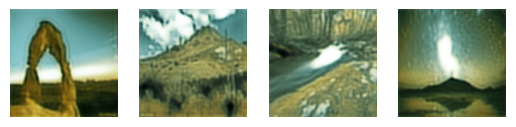

In [15]:
ans = []
for i in range(4):
    ans.append(Image.open('./cc/monet_img_'+str(i)+'_10.png'))

fix, axs = plt.subplots(1, 4)
axs = axs.flatten()
for img, ax in zip(ans, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

It look a bit like painting now. So, I use this to sbumit and got score 144.31192 
I think we can add more filters to increase complexity which would make model better.

In [23]:
# Get the generators
gen_G = get_resnet_generator(filters=8, num_residual_blocks=9, name="generator_G")
gen_F = get_resnet_generator(filters=8, num_residual_blocks=9, name="generator_F")

# Get the discriminators
disc_X = get_discriminator(filters=8, name="discriminator_X")
disc_Y = get_discriminator(filters=8, name="discriminator_Y")

In [24]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_ds, monet_ds)),
    epochs=10,
    callbacks=[plotter, model_checkpoint_callback],
)

Epoch 1/10


2023-08-17 08:01:42.436725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


    300/Unknown - 461s 1s/step - G_loss: 5.3529 - F_loss: 6.2054 - D_X_loss: 0.2256 - D_Y_loss: 0.1980

2023-08-17 08:08:59.993600: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4166810319489498590
2023-08-17 08:08:59.993615: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11821338220613436860
2023-08-17 08:08:59.993619: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15826280498639782145
2023-08-17 08:08:59.993639: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 585464430334543281
2023-08-17 08:08:59.993645: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16542833487134170949


300/300 [==============================] - 462s 1s/step - G_loss: 5.3429 - F_loss: 6.2067 - D_X_loss: 0.2250 - D_Y_loss: 0.1977
Epoch 2/10
300/300 [==============================] - 152s 505ms/step - G_loss: 4.6477 - F_loss: 5.4028 - D_X_loss: 0.0504 - D_Y_loss: 0.1153
Epoch 3/10
300/300 [==============================] - 176s 585ms/step - G_loss: 4.4139 - F_loss: 5.1366 - D_X_loss: 0.1380 - D_Y_loss: 0.2026
Epoch 4/10
300/300 [==============================] - 216s 716ms/step - G_loss: 4.1929 - F_loss: 4.7422 - D_X_loss: 0.1746 - D_Y_loss: 0.2077
Epoch 5/10
300/300 [==============================] - 267s 887ms/step - G_loss: 4.1410 - F_loss: 4.5886 - D_X_loss: 0.1715 - D_Y_loss: 0.1713
Epoch 6/10
300/300 [==============================] - 202s 671ms/step - G_loss: 4.1426 - F_loss: 4.4226 - D_X_loss: 0.1743 - D_Y_loss: 0.1788
Epoch 7/10
300/300 [==============================] - 263s 877ms/step - G_loss: 3.7841 - F_loss: 4.1972 - D_X_loss: 0.1837 - D_Y_loss: 0.2431
Epoch 8/10
300/300 [

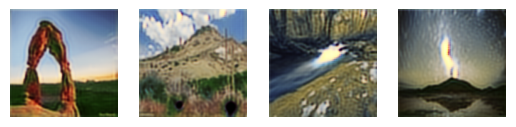

In [25]:
ans = []
for i in range(4):
    ans.append(Image.open('./cc/monet_img_'+str(i)+'_10.png'))

fix, axs = plt.subplots(1, 4)
axs = axs.flatten()
for img, ax in zip(ans, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

This result not much better for me. But score from kaggle is better a lot which is 92.07118.
I will try to increase epochs to 20 (10 more). It should be better.

In [30]:
cycle_gan_model.load_weights('./model_checkpoints/cyclegan_checkpoints.010')

In [31]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_ds, monet_ds)),
    epochs=5,
    callbacks=[plotter, model_checkpoint_callback],
)

Epoch 1/5
    300/Unknown - 207s 690ms/step - G_loss: 3.6353 - F_loss: 4.0811 - D_X_loss: 0.1859 - D_Y_loss: 0.2152

2023-08-17 09:53:44.790553: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4166810319489498590
2023-08-17 09:53:44.790571: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11821338220613436860
2023-08-17 09:53:44.790575: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15826280498639782145
2023-08-17 09:53:44.790585: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 585464430334543281
2023-08-17 09:53:44.790588: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16542833487134170949


300/300 [==============================] - 208s 693ms/step - G_loss: 3.6323 - F_loss: 4.0785 - D_X_loss: 0.1861 - D_Y_loss: 0.2152
Epoch 2/5
300/300 [==============================] - 188s 624ms/step - G_loss: 3.5885 - F_loss: 3.9572 - D_X_loss: 0.2056 - D_Y_loss: 0.2094
Epoch 3/5
300/300 [==============================] - 133s 443ms/step - G_loss: 3.5839 - F_loss: 3.8674 - D_X_loss: 0.2120 - D_Y_loss: 0.2067
Epoch 4/5
300/300 [==============================] - 329s 1s/step - G_loss: 3.8566 - F_loss: 4.2387 - D_X_loss: 0.2034 - D_Y_loss: 0.2055
Epoch 5/5
300/300 [==============================] - 285s 948ms/step - G_loss: 3.5944 - F_loss: 3.8880 - D_X_loss: 0.1872 - D_Y_loss: 0.1939


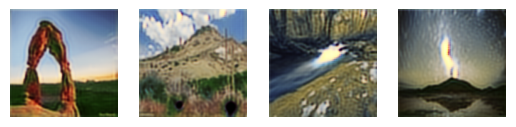

In [32]:
ans = []
for i in range(4):
    ans.append(Image.open('./cc/monet_img_'+str(i)+'_10.png'))

fix, axs = plt.subplots(1, 4)
axs = axs.flatten()
for img, ax in zip(ans, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

This model has lower kaggle socre which is 104.65926. I think it's overfitted.

## Conclusion
First we do some data analysis. Since it's images we can do much. Then, I create CycleGAN model. After I have first model I use it as basedline and de hyper-parameter tuning to improve model quality. This is my first GAN model. So, I learn most thing from tutorial. This model which process high quality image took a lot of time in training. I think improvement of this is adding dropout to fix overfitted issue. But, I think I already spent a lot of time on this. So, I might come back to improve this later.

## References
https://keras.io/examples/generative/cyclegan/

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial